In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from stix2.v21 import (ThreatActor, Identity, AttackPattern, Campaign, IntrusionSet, Relationship, ExternalReference, Bundle, Grouping)
from efficient_apriori import apriori
import re

In [2]:
df = pd.read_csv("Categorized_Adversary_TTPs.csv") # sample dataset of attacks
df.head()

,mitre_attack_id,mitre_attack_name,mitre_attack_aliases,mitre_attack_created,mitre_attack_last_modified,etda_id,etda_name,etda_aliases,etda_first_seen,country,motivation,victim_industries,victim_countries,mitre_attack_ttps
0,intrusion-set--dc5e2999-ca1a-47d4-8d12-a6984b1...,UNC2452,"['UNC2452', 'NOBELIUM', 'StellarParticle', 'Da...",2021-01-05,2021-05-04,93ba9804-335e-4782-855d-40af22b93201,"APT 29, Cozy Bear, The Dukes","['APT 29', 'Cozy Bear', 'The Dukes', 'Group 10...",2008,RU,['Information theft and espionage'],"['Defense', 'Energy', 'Government', 'Law enfor...","['Australia', 'Azerbaijan', 'Belarus', 'Belgiu...","['T1484.002', 'T1071.001', 'T1053.005', 'T1036..."
1,intrusion-set--8f5e8dc7-739d-4f5e-a8a1-a66e004...,Cleaver,"['Cleaver', 'Threat Group 2889', 'TG-2889']",2017-05-31,2021-10-12,4622bc44-8c01-4807-8d12-b22352472c29,"Cutting Kitten, TG-2889","['Cutting Kitten', 'TG-2889', 'Operation “Clea...",2012,IR,['Information theft and espionage'],"['Aerospace', 'Aviation', 'Chemical', 'Defense...","['Canada', 'China', 'France', 'Germany', 'Indi...","['T1588.002', 'T1003.001', 'T1587.001', 'T1585..."
2,intrusion-set--0ea72cd5-ca30-46ba-bc04-378f701...,GCMAN,['GCMAN'],2017-05-31,2020-03-30,e6eeb30a-a941-46f9-8340-20958f1d6cb0,GCMAN,['GCMAN'],2016,RU,['Financial crime'],['Financial'],['Russia'],"['T1021.005', 'T1021.004']"
3,intrusion-set--dd2d9ca6-505b-4860-a604-233685b...,Wizard Spider,"['Wizard Spider', 'UNC1878', 'TEMP.MixMaster',...",2020-05-12,2021-10-14,480940e0-47b0-4295-9067-c2500ccfdaec,"Wizard Spider, Gold Blackburn","['Wizard Spider', 'Grim Spider', 'TEMP.MixMast...",2014,RU,"['Financial crime', 'Financial gain']","['Defense', 'Financial', 'Government', 'Health...",None Provided,"['T1053.005', 'T1033', 'T1070.004', 'T1059.003..."
4,intrusion-set--f9d6633a-55e6-4adc-9263-6ae0804...,Magic Hound,"['Magic Hound', 'TA453', 'COBALT ILLUSION', 'C...",2018-01-16,2022-04-17,bb9b25ed-9ddc-4f65-bd01-ab8d6efc34ac,"Magic Hound, APT 35, Cobalt Gypsy, Charming Ki...","['Magic Hound', 'APT 35', 'Cobalt Illusion', '...",2012,IR,['Information theft and espionage'],"['Defense', 'Energy', 'Financial', 'Government...","['Afghanistan', 'Canada', 'Egypt', 'Iran', 'Ir...","['T1071', 'T1564.003', 'T1560.001', 'T1586.002..."


In [3]:
from pyattck import Attck

attack = Attck()

#dictionary for high speed access
actors = {}
for actor in attack.enterprise.actors:
    actors[actor.id] = actor
malwares = attack.enterprise.malwares + attack.enterprise.tools
ttpLists = []
for malware in malwares:
    ttpLists.append(["'" + ttp.id + "'" for ttp in malware.techniques])

In [4]:
# to use the apriori we need to generate a list of lists
aprList = []
for row in df.values:
    aprList.append((row[13].strip('][').split(', ')))

In [5]:
aprList += ttpLists
len(aprList)

746

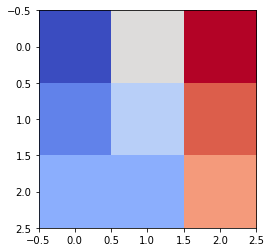

In [6]:
import matplotlib.pyplot as plt

# Your list of lists of confidence values
confidences = [[0.1, 0.5, 0.9], [0.2, 0.4, 0.8], [0.3, 0.3, 0.7]]

plt.imshow(confidences, cmap='coolwarm')
plt.show()

In [7]:
# calculate the support of a ttp value where data is a list of lists and ttps is a list of ttps
def calculateSupport(ttps, data):
    count = sum([1 for l in data if set(ttps).issubset(set(l))])
    support = count/len(data)
    return support


calculateSupport(["'T1566.002'", "'T1204.002'"], aprList)

0.06166219839142091

In [8]:
# calculates the confidence of 1:1 rule where data is a list of lists
# anticedant and consequent are lists such that anticedant -> consequent
def calculateConfidence(anticedant, consequent, data):
    if anticedant == consequent:
        return 1
    return calculateSupport(anticedant+consequent, data)/calculateSupport(anticedant, data)

calculateConfidence(["'T1583.002'"], ["'T1583.002'"], aprList)

1

In [48]:
# loop through set of all TTPs
ttps = sorted(list(set([item for sublist in aprList for item in sublist])))
ttps.pop(1)
size = len(ttps)
confidenceMatrix = []
supportMatrix = []

for rowTTP in ttps[0:size]:
    curRow = []
    for colTTP in ttps[0:size]:
        curRow.append(calculateConfidence([rowTTP], [colTTP], aprList))
    confidenceMatrix.append(curRow)

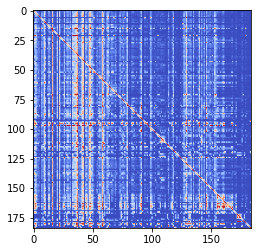

In [49]:
plt.imshow(confidenceMatrix, cmap="coolwarm")
plt.show()

In [39]:
for row in confidenceMatrix:
    print(row)

[0, 9, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 9, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 9, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 9, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 9, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 9, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 9, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 9, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 9, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 9, 0, 0, 0, 0, 0, 0, 0, 0]


In [48]:
confidenceMatrix[4][4]

1

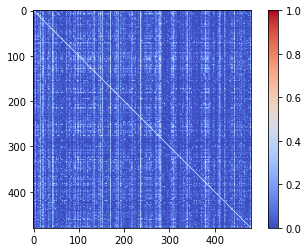

In [50]:
fig, ax = plt.subplots()
heatmap = ax.imshow(confidenceMatrix, cmap='coolwarm')
fig.colorbar(heatmap)


plt.show()

In [12]:
abstractData = aprList
for i in range(0,len(abstractData)):
    abstractData[i] = [re.sub(r'\.[0-9]+', '', ttp) for ttp in abstractData[i]]

In [45]:
ttps = sorted(list(set([item for sublist in abstractData for item in sublist if item != "''"])))
ttps.pop(1)
size = len(ttps)

confidenceMatrix = []
supportMatrix = []

for rowTTP in ttps[0:size]:
    curRow = []
    for colTTP in ttps[0:size]:
        curRow.append(calculateConfidence([rowTTP], [colTTP], aprList))
    confidenceMatrix.append(curRow)

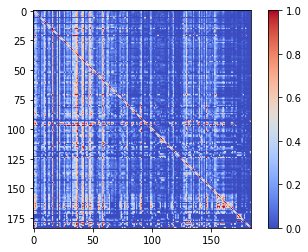

In [46]:
fig, ax = plt.subplots()
heatmap = ax.imshow(confidenceMatrix, cmap='coolwarm')
fig.colorbar(heatmap)


plt.show()

In [42]:
len(ttps)

184

In [32]:
# table of rules and then support, lift, confidence 
size

185

In [44]:
sorted(ttps)

["'T1001'",
 "'T1003'",
 "'T1005'",
 "'T1007'",
 "'T1008'",
 "'T1010'",
 "'T1011'",
 "'T1012'",
 "'T1014'",
 "'T1016'",
 "'T1018'",
 "'T1019'",
 "'T1020'",
 "'T1021'",
 "'T1025'",
 "'T1026'",
 "'T1027'",
 "'T1029'",
 "'T1030'",
 "'T1032'",
 "'T1033'",
 "'T1034'",
 "'T1036'",
 "'T1037'",
 "'T1039'",
 "'T1040'",
 "'T1041'",
 "'T1043'",
 "'T1046'",
 "'T1047'",
 "'T1048'",
 "'T1049'",
 "'T1052'",
 "'T1053'",
 "'T1055'",
 "'T1056'",
 "'T1057'",
 "'T1059'",
 "'T1065'",
 "'T1068'",
 "'T1069'",
 "'T1070'",
 "'T1071'",
 "'T1072'",
 "'T1074'",
 "'T1078'",
 "'T1080'",
 "'T1082'",
 "'T1083'",
 "'T1087'",
 "'T1090'",
 "'T1091'",
 "'T1092'",
 "'T1094'",
 "'T1095'",
 "'T1098'",
 "'T1102'",
 "'T1104'",
 "'T1105'",
 "'T1106'",
 "'T1110'",
 "'T1111'",
 "'T1112'",
 "'T1113'",
 "'T1114'",
 "'T1115'",
 "'T1119'",
 "'T1120'",
 "'T1123'",
 "'T1124'",
 "'T1125'",
 "'T1127'",
 "'T1129'",
 "'T1132'",
 "'T1133'",
 "'T1134'",
 "'T1135'",
 "'T1136'",
 "'T1137'",
 "'T1140'",
 "'T1176'",
 "'T1185'",
 "'T1187'",
 "'T